<Info | 7 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
>


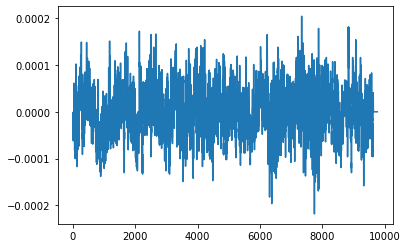

In [16]:
from fn_cfg import *
import params as cfg

local_dir = '/Users/joshuaighalo/Downloads/files-2'
edf_data = mne.io.read_raw_edf(local_dir+'/S001/S001R02.edf')
raw_data = edf_data.get_data()
info = edf_data.info
channels = edf_data.ch_names
data_Cz = raw_data[10]
print(info)
plt.plot(data_Cz)
fs = int(info['sfreq'])

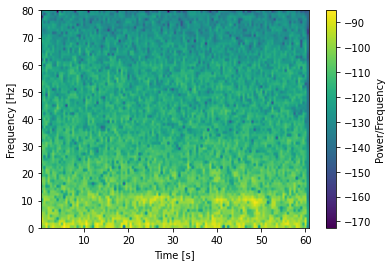

In [14]:
plt.figure('Spectrogram')
d, f, t, im = plt.specgram(data_Cz, NFFT=fs, Fs=fs, noverlap=fs/2)
plt.colorbar(label= "Power/Frequency")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.show()

In [15]:
files_EO = []
for root, dirs, files in os.walk(local_dir):
    if files:
        files_EO.append(sorted(files)[0])